In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats


ModuleNotFoundError: No module named 'adjustText'

### Initializing DepMap database classes.

In [2]:
class DepMap:
    """
    This class allows for interaction with the data found in the Achilles and
    DEMETER2 data set from the public DepMap portal. 
    """

    def __init__(self):
        self.load_achilles()
        self.load_rnai()
        self.load_guides()
        self.load_mutations()

    # DepMap dataset load in
    def load_achilles(self, achilles_path="../data/depmap/20Q1/202020226_Achilles_gene_effect.csv"):
        """
        This function loads in the Achilles data. The path to data file is
        optional and only required if there is an updated or older version of
        the data to be used. That is the only time this function needs to be
        manually called, otherwise it will be called during object
        initialization.
        
        :param achilles_path: (str) path to Achilles data set.

        :return: (None) Initializes raw_achilles and achilles attributes.
        """
        self.achilles = Achilles(achilles_path)

    def load_rnai(self, rnai_path="../data/depmap/20Q1/20200226_D2_combined_gene_dep_scores.csv"):
        """
        This function loads in the RNAi (DEMETER2) data. The path to data file is
        optional and only required if there is an updated or older version of
        the data to be used. That is the only time this function needs to be
        manually called, otherwise it will be called during object
        initialization.
        
        :param rnai_path: (str) path to RNAi data set.

        :return: (None) Initializes raw_rnai and rnai attributes.
        """
        self.rnai = RNAi(rnai_path)

    def load_guides(self, guide_path="../data/depmap/20Q1/20200304_Achilles_guide_map.csv"):
        """
        This function loads in the CRISPR guide data. The path to data file is
        optional and only required if there is an updated or older version of
        the data to be used. That is the only time this function needs to be
        manually called, otherwise it will be called during object
        initialization.
        
        :param guide_path: (str) path to CRISPR guide data set.

        :return: (None) Initializes guide attributes.
        """
        self.guides = CRISPRGuides(guide_path)

    def load_mutations(self, mutation_path="../data/depmap/20Q1/20200309_CCLE_mutations.csv"):
        """
        This function loads in the DepMap mutation data. The path to data file is
        optional and only required if there is an updated or older version of
        the data to be used. That is the only time this function needs to be
        manually called, otherwise it will be called during object
        initialization.

        :param mutation_path: (str) path to DepMap mutation data.

        :return: (None) Initializes mutation attribute.
        """
        self.mutations = Mutation(mutation_path)

    # Plotting functions
    def plot_distributions(self, gene_list, save=False):
        for gene in gene_list:
            show = not save
            self._make_distribution(gene, show=show)

    def plot_alignments(self, thr=5, show=True):
        self._make_alignments_ceres(thr, show)

    def _make_alignments_ceres(self, thr, show=True):
        """
        This function plots the mean CERES score from all cell lines for each
        gene on the x-axis and the mean number of alignments of the guide
        targeting that specific gene. It colors and labels all points with the
        number of alignments greater than or equal to the provided threshold
        that also have a CERES score less than or equal to -0.5.

        :params thr: (int) The threshold for the number of alignments above
            which (inclusive) to color and label.
        :params show: (bool) default is True. Whether to show the plot or to
            save it. It saves the plot to ../output/{hlp.insert_date()}/figures/DepMap/

        :return: (None). Shows plot or saves to indicated path.
        """
        # Averaging number of alignments per gene
        alignments = self.guides.guides_data["n_alignments"].astype("int")
        alignments = alignments.groupby("gene").aggregate(np.mean).sort_values()
        
        # Avering CERES score per gene
        achilles_avg = self.achilles.achilles_data.mean(axis=0)
        
        # Only selecting genes which are in both data sets
        common_genes = set(achilles_avg.index).intersection(set(alignments.index))
        achilles_avg = achilles_avg[common_genes].sort_index()
        alignments = alignments[common_genes].sort_index()

        # Filtering based on threshold and CERES score
        selected_genes = set(alignments[alignments >= thr].index).intersection(
            set(achilles_avg[achilles_avg <= -0.5].index))
        selected_indices = alignments.index.isin(selected_genes)
        
        # Saving genes below threshold for cuts and below -0.5 for dependency
        target_genes = set(alignments[alignments < thr].index).intersection(
            set(achilles_avg[achilles_avg <= -0.5].index))
        with open("../code/tmp/06_Dependent_LowCuts.csv", "w") as f:
            f.write(','.join(list(target_genes)))
            
        # Plotting
        fig, ax = plt.subplots()
        ax.scatter(achilles_avg.values[selected_indices], 
                   alignments.values[selected_indices], s=1, color="r")
        ax.scatter(achilles_avg.values[~selected_indices],
                   alignments.values[~selected_indices], s=1)
        
        for index in [i for i, x in enumerate(selected_indices) if x]:
            ax.annotate(alignments.index[index], 
                        (achilles_avg.values[index], alignments.values[index]), 
                        fontsize=4)
        plt.xlim(min(achilles_avg.values)-0.05, 0)
        plt.xlabel("Gene Effect")
        plt.ylabel("Mean Number of Guide Alignments")

        if show:
            plt.show()
        else:
            if not os.path.exists(f"../output/{hlp.insert_date()}/figures/DepMap/"):
                os.path.makedirs(f"../output/{hlp.insert_date()}/figures/DepMap/")
            plt.savefig(f"../output/{hlp.insert_date()}/figures/DepMap/{hlp.insert_date()}-GuideAlignments-CERES-thr-{thr}.pdf")
            plt.close()

    def _make_distribution(self, gene, show=True):
        """
        This function plots distributions of the Achilles and RNAi data similar
        to those provided on the DepMap portal. 

        :params gene: (str) the gene name to make the distribution plot for.
        :params show: (bool) default is True. Whether to show the plot or to
            save it. It saves the plot to ../output/{hlp.insert_date()}/figures/DepMap/
        
        :return: (None). Shows plot or saves to indicaetd path.
        """
        try:
            sns.distplot(self.achilles.achilles_data[gene], hist=False, color="#2fa3de", 
                        kde_kws={"shade": True, "color": "#2fa3de"}, label="Achilles")
        except KeyError:
            print(f"\t\tData for gene symbol {gene} not in Achilles data.")

        try:
            sns.distplot(self.rnai.rnai_data[gene], hist=False, color="#a86ce0", 
                        kde_kws={"shade": True, "color": "#a86ce0"}, label="RNAi")
        except KeyError:
            print(f"\t\tData for gene symbol {gene} not in RNAi data.")

        yrange = plt.gca().get_ylim()
        plt.vlines([-1, 0], ymin=0, ymax=yrange[1], colors=["r", "k"],
                linestyles=["dashed", "solid"])
        plt.yticks([])
        plt.xlabel("Gene Effect")
        if show:
            plt.title(gene)
            plt.show()
        else:
            if not os.path.exists(f"../output/{hlp.insert_date()}/figures/DepMap/Dependency-Distributions/"):
                os.makedirs(
                    f"../output/{hlp.insert_date()}/figures/DepMap/Dependency-Distributions/")
            plt.savefig(
                f"../output/{hlp.insert_date()}/figures/DepMap/Dependency-Distributions/{hlp.insert_date()}-DepMapPlot-{gene}.pdf")
            plt.close()

        return None


class Mutation:
    """
    This class allows for easy interaction with and interrogation of the CCLE
    mutation data set.
    """

    def __init__(self, mutation_path):
        self._load_mutations(mutation_path)
        self._top_mutations = None

    def _load_mutations(self, mutation_path):
        """
        This function loads in the DepMap mutation data. The path to data file is
        optional and only required if there is an updated or older version of
        the data to be used. That is the only time this function needs to be
        manually called, otherwise it will be called during object
        initialization.

        :param mutation_path: (str) path to DepMap mutation data.

        :return: (None) Initializes mutation attributes.
        """
        self.mutations_data = pd.read_csv(mutation_path)
        self.mutations_data.set_index("Unnamed: 0", inplace=True)
        # Safer data extraction
        self.mutations_data.fillna(value=False, inplace=True)
        return None

    def cell_line_extract(self, gene, mutation_class=False, mutation_type=False, tcga_count=0,
                          cosmic_count=0, deleterious=False, tcga_hotspot=False, cosmic_hotspot=False):
        """
        This function returns the cell line IDs which have a mutation in the
        given gene. This result can be further filtered by the specific optional
        parameters.

        :param gene: (str) Hugo_Symbol of gene name to be searched.
        :param mutation_class: (str) optional. Return cell lines with a mutation
            in the provided gene with this classification. 
            Classes are: 
            ['Silent', 'Missense_Mutation', 'In_Frame_Del', 'Nonsense_Mutation',
            'Frame_Shift_Ins', 'Splice_Site', 'Intron','De_novo_Start_OutOfFrame', 'Frame_Shift_Del', 'Start_Codon_SNP', 'In_Frame_Ins', 'Nonstop_Mutation', "5'UTR", "5'Flank", 'Stop_Codon_Del', 'Start_Codon_Del', 'IGR', 'Stop_Codon_Ins',
            'Start_Codon_Ins', "3'UTR"]
        :param mutation_type: (str) optional. Return cell lines with a mutation
            in the provided gene with this mutation type.
            Options are: ['SNP', 'DEL', 'INS', 'DNP', 'TNP']
        :param tcga_count: (int) optional. Return cell lines with a mutation in
            the provided gene with at least this number of times this mutation is observed in
            TCGA.
        :param cosmic_count: (int) optional. Return cell lines with a
            the provided gene with at least this number of times this mutation
            is observed in COSMIC.
        :param deleterious: (bool) optional. Return cell lines with a
            mutation in the provided gene only if the the mutation is deleterious.
        :param tcga_hotspot: (bool) optional. Return cell lines with a
            mutation in the provided gene only if this mutation is commonly
            found in TCGA.
        :param cosmic_hotspot: (bool) optional. Return cell lines with a
            mutation in the provided gene only if this mutation is commonly
            found in COSMIC.

        :return: (List) A list of cell lines with a mutation in the provided
            gene meeting all of the different parameter options provided.
        """
        filtered_mutations = self.mutations_data[self.mutations_data["Hugo_Symbol"] == gene]
        
        # Matching function parameters to DepMap mutation table columns and
        # parameter value. Using ordered structure of dict.
        parameters = {"Variant_Classification": mutation_class,
                      "Variant_Type": mutation_type, 
                      "TCGAhsCnt": tcga_count,
                      "COSMIChsCnt": cosmic_count,
                      "isDeleterious": deleterious,
                      "isTCGAhotspot": tcga_hotspot,
                      "isCOSMIChotspot": cosmic_hotspot}

        # Need to do below to allow for filtering only when user supplies a
        # parameter.
        filter_conditions = np.array(list(parameters.keys()))
        fil = np.array([mutation_class, mutation_type, bool(tcga_count), bool(cosmic_count),
                        deleterious, tcga_hotspot, cosmic_hotspot])
        filter_conditions = filter_conditions[fil]

        # Iterating over user selected parameters and filtering data
        for column in filter_conditions:
            if column.startswith("is"):  # Boolean Filters
                filtered_mutations = filtered_mutations[filtered_mutations[column]]
            elif column.endswith("Cnt"):  # Count Filters
                filtered_mutations = \
                    filtered_mutations[filtered_mutations[column]
                                       >= parameters[column]]
            else:  # String Matching
                filtered_mutations = filtered_mutations[filtered_mutations[column]
                                                        == parameters[column]]
        return filtered_mutations

    def top_mutations(self):
        # Prevents redoing calculation if already requested
        if not self._top_mutations:
            self._get_top_mutations()
            
        return self._top_mutations
    
    def _get_top_mutations(self):
        """
        This function returns the top mutations in the mutations data set. It
        pre-filters the list of all genes to be TCGA hotspots to counter act the
        effect of longer genes having more mutations naturally. It is assumed
        that TCGA already accounts for this difference.
        """
        self._top_mutations = self.mutations_data[self.mutations_data["isTCGAhotspot"]]
        self._top_mutations = self._top_mutations.groupby("Hugo_Symbol").count()
        self._top_mutations = self._top_mutations.sort_values("DepMap_ID",
                                                              ascending=False)
        
        # Want it to be immutable since it's already sorted
        self._top_mutations = tuple(zip(tuple(self._top_mutations.index), 
                                  tuple(self._top_mutations["DepMap_ID"])))
        return None


class RNAi:
    """
    This class allows for interaction with and interrogation of the RNAi
    DEMETER2 dataset.
    """
    def __init__(self, rnai_path):
        self._load_rnai(rnai_path)

    def _load_rnai(self, rnai_path):
        """
        This function loads in the RNAi (DEMETER2) data. The path to data file is
        optional and only required if there is an updated or older version of
        the data to be used. That is the only time this function needs to be
        manually called, otherwise it will be called during object
        initialization.

        :param rnai_path: (str) path to RNAi data set.

        :return: (None) Initializes raw_rnai and rnai attributes.
        """
        self.raw_rnai = pd.read_csv(rnai_path)
        self._reformat_rnai_data()
        return None

    def _reformat_rnai_data(self):
        """
        This function reformats the raw RNAi data. It reindexes the
        data by the Tissue ID and then fixes the gene names to remove extraneous
        symbols.
        
        :return: (None) Sets self.rnai to a reindexed and cleaned up version of the raw
            data for use in downstream analysis.
        """
        updated_data = self.raw_rnai.set_index("Unnamed: 0")
        updated_data = updated_data.transpose()
        updated_data.columns = updated_data.columns.str.replace(
            "\s\(\\d+\)", "", regex=True)
        self.rnai_data = updated_data
        return None


class Achilles:
    """
    This class allows for interaction with and interrogation of the CRISPR
    Achilles dataset.
    """
    def __init__(self, achilles_path):
        self._load_achilles(achilles_path)

    def _load_achilles(self, achilles_path):
        """
        This function loads in the Achilles data. The path to data file is
        optional and only required if there is an updated or older version of
        the data to be used. That is the only time this function needs to be
        manually called, otherwise it will be called during object
        initialization.

        :param achilles_path: (str) path to Achilles data set.

        :return: (None) Initializes raw_achilles and achilles attributes.
        """
        self.raw_achilles = pd.read_csv(achilles_path)
        self._reformat_achilles_data()
        return None


    def _reformat_achilles_data(self):
        """
        This function reformats the raw dependency data so that information
        regarding tissue specific dependencies can be extracted. It reindexes the
        data by the DepMap_ID and then fixes the gene names to remove extraneous
        symbols.

        :return: (None) sets self.achilles to a reindexed and cleaned up version of the raw
            dependency probability data for use in downstream analysis.
        """
        dependency_data_update = self.raw_achilles.rename(
            columns={"Unnamed: 0": "DepMap_ID"})
        dependency_data_update = dependency_data_update.set_index(
            "DepMap_ID")

        dependency_data_update.columns = dependency_data_update.columns.str.replace(
            " \(\\d+\)", "", regex=True)

        self.achilles_data = dependency_data_update
        return None


class CRISPRGuides:
    """
    This class allows for interaction with and interrogation of the CRISPR
    Guides dataset.
    """
    def __init__(self, guides_path):
        self._load_guides(guides_path)

    def _load_guides(self, guide_path="../data/depmap/20Q1/20200304_Achilles_guide_map.csv"):
        """
        This function loads in the CRISPR guide data. The path to data file is
        optional and only required if there is an updated or older version of
        the data to be used. That is the only time this function needs to be
        manually called, otherwise it will be called during object
        initialization.
        
        :param guide_path: (str) path to CRISPR guide data set.

        :return: (None) Initializes guide attributes.
        """
        self.raw_guides = pd.read_csv(guide_path)
        self._reformat_guides()

    def _reformat_guides(self):
        """
        This function reformats the raw guides data. It reindexes the
        data by the gene and also fixes the gene names to remove extraneous
        symbols.
        
        :return: (None) Sets self.guides to a reindexed and cleaned up version of the raw
            data for use in downstream analysis.
        """
        updated_guides = self.raw_guides.set_index("gene")
        updated_guides = updated_guides.transpose()
        updated_guides.columns = updated_guides.columns.str.replace(
            " \(\\d+\)", "", regex=True)
        updated_guides = updated_guides.transpose()
        self.guides_data = updated_guides.sort_index()
        return None

In [3]:
depmap = DepMap()

/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (20,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()


In [4]:
sample_info = pd.read_csv("../data/depmap/20Q1/20200227_sample_info_public.csv")

## Mean CERES Score Difference

In [7]:
kras_mut = depmap.mutations.mutations_data[depmap.mutations.mutations_data["Hugo_Symbol"] == "KRAS"]["DepMap_ID"].unique().tolist()
kras_wt = depmap.mutations.mutations_data[depmap.mutations.mutations_data["Hugo_Symbol"] != "KRAS"]["DepMap_ID"].unique().tolist()

In [8]:
kras_mut_achilles = depmap.achilles.achilles_data.loc[kras_mut, :].dropna()
kras_wt_achilles = depmap.achilles.achilles_data.loc[kras_wt, :].dropna()

/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [9]:
mean_ceres_mut = kras_mut_achilles.mean(axis=0)
mean_ceres_wt = kras_wt_achilles.mean(axis=0)

In [10]:
test_results = scipy.stats.ttest_ind(kras_mut_achilles, kras_wt_achilles, equal_var=False)

In [11]:
mean_difference = mean_ceres_mut - mean_ceres_wt

In [12]:
data = {"genes": mean_difference.index, "differences": mean_difference.values, "logp": -np.log10(test_results[1])}

plot_df = pd.DataFrame(data)

In [11]:
plot_df.to_csv("../output/KRAS_Mut_Wt_Group_Differences_Volcano.csv", index=False)

### Making Plot with Broken Axes

First need to extract only negative differences for plot and make these values the absolute value.

In [13]:
plot_negative = plot_df[plot_df["differences"] < 0]
plot_negative["differences"] = abs(plot_negative["differences"])
plot_negative["color"] = ['r' if x >= 1.301 else 'k' for x in plot_negative['logp']]
plot_negative

/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,genes,differences,logp,color
2,A2M,0.002613,0.098647,k
3,A2ML1,0.014006,0.679085,k
6,A4GNT,0.004531,0.148413,k
7,AAAS,0.007392,0.201896,k
9,AADAC,0.022262,0.944062,k
...,...,...,...,...
18314,ZSWIM2,0.011716,0.471704,k
18319,ZSWIM7,0.041437,2.244959,r
18321,ZUP1,0.008913,0.373416,k
18328,ZYG11A,0.006189,0.228736,k


/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Users/kevinkapner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


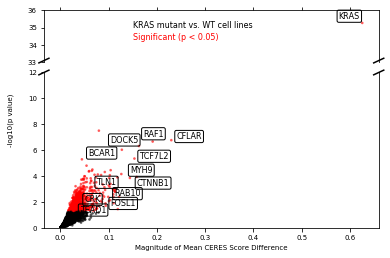

In [24]:
# Axis breaking method taken from https://matplotlib.org/examples/pylab_examples/broken_axis.html

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3]})

# plot the same data on both axes
ax.scatter(plot_negative["differences"], plot_negative["logp"], 
           c=plot_negative["color"], alpha=0.5, s=3)
ax2.scatter(plot_negative["differences"], plot_negative["logp"],
            c=plot_negative["color"], alpha=0.5, s=3)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(33, 36)  # outliers only
ax2.set_ylim(0, 12)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d*5), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d*5), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

f.subplots_adjust(hspace=0.1)

texts=[]

# Naming select points
labeled_points = ["FOSL1"]

ax.annotate("KRAS", (plot_negative[plot_negative["genes"] == "KRAS"]["differences"]-0.05,
                  plot_negative[plot_negative["genes"] == "KRAS"]["logp"]-1.7),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("MYH9", (plot_negative[plot_negative["genes"] == "MYH9"]["differences"],
                  plot_negative[plot_negative["genes"] == "MYH9"]["logp"]+0.1),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("TEAD1", (plot_negative[plot_negative["genes"] == "TEAD1"]["differences"]-.02,
                  plot_negative[plot_negative["genes"] == "TEAD1"]["logp"]-0.3),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("RAF1", (plot_negative[plot_negative["genes"] == "RAF1"]["differences"]-0.02,
                  plot_negative[plot_negative["genes"] == "RAF1"]["logp"]-0.1),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("DOCK5", (plot_negative[plot_negative["genes"] == "DOCK5"]["differences"]-0.06,
                  plot_negative[plot_negative["genes"] == "DOCK5"]["logp"]-0.2),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("BCAR1", (plot_negative[plot_negative["genes"] == "BCAR1"]["differences"]-0.07,
                  plot_negative[plot_negative["genes"] == "BCAR1"]["logp"]-0.85),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("CTNNB1", (plot_negative[plot_negative["genes"] == "CTNNB1"]["differences"],
                  plot_negative[plot_negative["genes"] == "CTNNB1"]["logp"]-0.9),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("CFLAR", (plot_negative[plot_negative["genes"] == "CFLAR"]["differences"]+0.01,
                  plot_negative[plot_negative["genes"] == "CFLAR"]["logp"]-0.4),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("TCF7L2", (plot_negative[plot_negative["genes"] == "TCF7L2"]["differences"]+0.01,
                  plot_negative[plot_negative["genes"] == "TCF7L2"]["logp"]-0.4),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("RAB10", (plot_negative[plot_negative["genes"] == "RAB10"]["differences"],
                  plot_negative[plot_negative["genes"] == "RAB10"]["logp"]-0.6),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("CRK", (plot_negative[plot_negative["genes"] == "CRK"]["differences"]-0.01,
                  plot_negative[plot_negative["genes"] == "CRK"]["logp"]+0.3),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)
ax2.annotate("TLN1", (plot_negative[plot_negative["genes"] == "TLN1"]["differences"],
                  plot_negative[plot_negative["genes"] == "TLN1"]["logp"]),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none',  edgecolor="black"),
                fontsize=8)
ax2.annotate("FOSL1", (plot_negative[plot_negative["genes"] == "FOSL1"]["differences"]+0.02,
                  plot_negative[plot_negative["genes"] == "FOSL1"]["logp"]-0.5),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor="black"),
                fontsize=8)

plt.xlabel("Magnitude of Mean CERES Score Difference", fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax.tick_params(labelsize=7)
f.text(0.04, 0.5, "-log10(p value)", va='center', rotation='vertical', fontsize=7)
plt.savefig("../output/FigureB_V2_MeanCERESScoreDifference_NegOnly_WithAxesBreak.pdf")

ax.annotate("KRAS mutant vs. WT cell lines", (0.15, 35), fontsize=8)
ax.annotate("Significant (p < 0.05)", (0.15, 34.3), c="r", fontsize=8)
plt.savefig("../output/FigureB_V2_MeanCERESScoreDifference_NegOnly_WithAxesBreak_withPlotText.pdf")


## RNAi Values

In [142]:
depmap.rnai.rnai_data.sort_values("KRAS")["KRAS"].to_csv("../output/KRAS_RNAi_Dependency_Values.txt",
                                                         sep="\t")

<ipython-input-142-d406893b34ca>:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  depmap.rnai.rnai_data.sort_values("KRAS")["KRAS"].to_csv("../output/KRAS_RNAi_Dependency_Values.txt",


## Dependency Stratification

In [143]:
kras_dependency_scores = pd.DataFrame(depmap.rnai.rnai_data.sort_values("KRAS")["KRAS"]).reset_index()
kras_dependency_scores.rename(columns = {"index": "CCLE_Name"}, inplace=True)

# Adding DepMap_ID to CCLE names
sample_info_dict = sample_info.set_index("CCLE_Name").to_dict()
kras_dependency_scores["DepMap_ID"] = kras_dependency_scores["CCLE_Name"].map(sample_info_dict["DepMap_ID"])

In [144]:
kras_depend = kras_dependency_scores[kras_dependency_scores["KRAS"] <= -0.5].dropna()
kras_independ = kras_dependency_scores[kras_dependency_scores["KRAS"] > -0.5].dropna()

In [145]:
kras_depend_achilles = depmap.achilles.achilles_data.loc[kras_depend["DepMap_ID"], :].dropna()
kras_independ_achilles = depmap.achilles.achilles_data.loc[kras_independ["DepMap_ID"], :].dropna()

In [146]:
mean_ceres_depend = kras_depend_achilles.mean(axis=0)
mean_ceres_independ = kras_independ_achilles.mean(axis=0)

In [147]:
dep_ind_test_results = scipy.stats.ttest_ind(kras_depend_achilles, kras_independ_achilles, equal_var=False)

In [148]:
mean_depend_difference = mean_ceres_depend - mean_ceres_independ

In [149]:
data = {"genes": mean_depend_difference.index, "differences": mean_depend_difference.values, "logp": -np.log10(dep_ind_test_results[1])}

plot_df = pd.DataFrame(data)
plot_df.to_csv("../output/KRAS_Dependency_Group_Differences_Volcano.csv", index=False)


## Calculating Correlations of Dependencies with BCAR1

1. Calculate pearson correlation between each gene CERES profiles.
2. Calculate Z-Scores of pearson correlations.
3. Z-Score > 3 can be considered correlated.

Source: https://depmap.org/rnai/data/index

In [88]:
achilles_data = depmap.achilles.achilles_data

In [89]:
bcar1_corr = achilles_data.corrwith(achilles_data["BCAR1"], axis=0, method="pearson")

In [90]:
bcar1_corr_zscore = (bcar1_corr - bcar1_corr.mean())/(bcar1_corr.std())

In [91]:
corr_genes = bcar1_corr_zscore[bcar1_corr_zscore > 3].index.to_list()

Printing out the highly correlated genes for input into STRING.

In [92]:
print('\n'.join(corr_genes))

ACTR2
ACTR3
AFDN
ALG14
ALG6
ANKRD11
ARHGEF12
ARHGEF7
ARPC2
ARPC3
ARPC4
ATRN
BCAR1
BCAR3
BRK1
BTBD3
CCDC113
CDC42
CDH2
CRK
CRKL
CTRB1
DLG5
DOCK5
DOCK7
DYNC1LI2
EFNA5
ELMO2
ELOVL1
FERMT2
FGFR1OP2
FNDC3B
FOSL1
GGNBP2
GLG1
GNB1
HSP90B1
ILK
ITGAV
ITGB5
KLHL20
KRAS
LIMS1
LPAR1
MARK2
MARK3
MESD
MGRN1
MOB4
MYO10
NCKAP1
OST4
PAK2
PAK4
PGAP2
PHACTR4
PIGT
PKN2
PPP2R5C
PTK2
PTPN1
PXN
RAC1
RAP1GDS1
RAPGEF1
RAPGEF6
RAPH1
RBBP7
RHOG
RIC8A
RSAD1
RSU1
RTCB
SEPT9
SETD5
SLC12A3
SLCO1C1
SRC
STT3A
TEAD1
TEAD4
TIPARP
TLN1
TM2D2
TM2D3
TNS3
TP53BP2
TRIO
TSPAN4
TULP4
UBIAD1
VASP
VCL
WWTR1
YES1
ZFP36L1


In [93]:
bcar1_corr_zscore.sort_values(ascending=False).to_csv("../output/BCAR1_Correlation_ZScores.txt", sep="\t")

<ipython-input-93-97aa11a5e8e9>:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  bcar1_corr_zscore.sort_values(ascending=False).to_csv("../output/BCAR1_Correlation_ZScores.txt", sep="\t")


In [94]:
print('\n'.join(bcar1_corr_zscore.sort_values(ascending=False).head(25).index.to_list()))

BCAR1
CRKL
PTK2
ILK
RAC1
TLN1
ITGAV
CRK
LIMS1
NCKAP1
RSU1
DOCK5
ELMO2
PKN2
RAPH1
MYO10
VCL
WWTR1
TRIO
ITGB5
PXN
FERMT2
RAPGEF1
MOB4
SRC


## KRAS Dependent Pancreatic Lines vs. Non-Pancreatic KRAS Independent

This data analysis follows the same method used for the KRAS dependent vs independent comparison, except that the the two groups being used for comparison are:
    1. KRAS dependent pancreatic lines
    2. Non-Pancreatic KRAS independent lines
    
The same dependency stratification can be used for identifying lines, since full CCLE names have the tissue name

In [95]:
kras_depend_panc = kras_depend[kras_depend["CCLE_Name"].str.contains("PANCREAS")]
kras_independ_non_panc = kras_independ[~kras_independ["CCLE_Name"].str.contains("PANCREAS")]

In [96]:
kras_depend_panc = depmap.achilles.achilles_data.loc[kras_depend_panc["DepMap_ID"], :].dropna()
kras_independ_non_panc = depmap.achilles.achilles_data.loc[kras_independ_non_panc["DepMap_ID"], :].dropna()

In [97]:
mean_ceres_panc = kras_depend_panc.mean(axis=0)
mean_ceres_non_panc = kras_independ_non_panc.mean(axis=0)

In [98]:
dep_ind_test_results_panc = scipy.stats.ttest_ind(kras_depend_panc, kras_independ_non_panc, equal_var=False)

In [99]:
mean_depend_difference_panc = mean_ceres_panc - mean_ceres_non_panc

In [100]:
data = {"genes": mean_depend_difference_panc.index, "differences": mean_depend_difference_panc.values, "logp": -np.log10(dep_ind_test_results_panc[1])}

plot_df = pd.DataFrame(data)
plot_df.to_csv("../output/KRAS_PancDependency_NonPancKRASIndependGroup_Differences.csv", index=False)

## STRING Network Processing

In [101]:
import networkx as nx

In [102]:
string_network = pd.read_csv("../output/Top25_BCAR1_Correlations_string_interactions-2.tsv", sep="\t")

edges = []
string_nodes = set(string_network["node1"].tolist()).union(
    set(string_network["node2"].tolist()))

for e in range(string_network.shape[0]):
    edges.append((string_network.at[e, "node1"],
                  string_network.at[e, "node2"],
                  {"weight": float(string_network.at[e, "combined_score"])}))
    
string_graph = nx.Graph()
string_graph.add_nodes_from(string_nodes)
string_graph.add_edges_from(edges)
nx.write_gml(string_graph, "../output/Top25_BCAR1Corr_StringGML.gml")